In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [107]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [108]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go



In [109]:
data = yf.download(tickers='ETH-USD', period = '1d', interval = '5m')


[*********************100%***********************]  1 of 1 completed


In [110]:
print(data["Open"])

Datetime
2022-12-26 00:00:00    1218.920166
2022-12-26 00:05:00    1218.316162
2022-12-26 00:10:00    1219.024170
2022-12-26 00:15:00    1218.763306
Name: Open, dtype: float64


In [111]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Open"] 

In [112]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= (  (y-x) / abs(x)  ) *100
    return perc_chg


In [113]:
def mail2me(message_text):
    from email.message import EmailMessage
    import smtplib

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    #password = input("Type your password and press enter: ")
    password =""
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"
    email.set_content(message_text)

    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()


In [114]:
# ETH-USD  GET CHANGES FOR 3MONTHS - 1 MONTH -1 WEEK INTERVALS

df3mo=getRates('ETH-USD',  '3mo',  '1h')
print(  getPercChange(df3mo) )
message_input0="ETH-USD',  '3mo',  '1h' " +str( getPercChange(df3mo)[0])

df1mo=getRates('ETH-USD',  '1mo',  '1h')
print(  getPercChange(df1mo) )
message_input1="ETH-USD',  '1mo',  '1h' " +str( getPercChange(df1mo)[0])

dfwk=getRates('ETH-USD',  '1wk',  '1h')
print(  getPercChange(dfwk) )
message_input2="ETH-USD',  '1wk',  '1h' " +str( getPercChange(dfwk)[0])

message_input=message_input0+"\n"+message_input1+"\n"+message_input2

mail2me(message_input)

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
[-5.83024969]
ETH-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
[1.67916233]
ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
[2.88344593]


In [115]:
# ALGO-USD  GET CHANGES FOR 3MONTHS - 1 MONTH -1 WEEK INTERVALS

df3mo=getRates('ALGO-USD',  '3mo',  '1h')
print(  getPercChange(df3mo) )
message_input0="ALGO-USD',  '3mo',  '1h' " +str( getPercChange(df3mo)[0])

df1mo=getRates('ALGO-USD',  '1mo',  '1h')
print(  getPercChange(df1mo) )
message_input1="ALGO-USD',  '1mo',  '1h' " +str( getPercChange(df1mo)[0])

dfwk=getRates('ALGO-USD',  '1wk',  '1h')
print(  getPercChange(dfwk) )
message_input2="ALGO-USD',  '1wk',  '1h' " +str( getPercChange(dfwk)[0])

message_input=message_input0+"\n"+message_input1+"\n"+message_input2

mail2me(message_input)

ALGO-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
[-57.34476135]
ALGO-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
[-31.90707641]
ALGO-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
[-12.19934364]


In [116]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


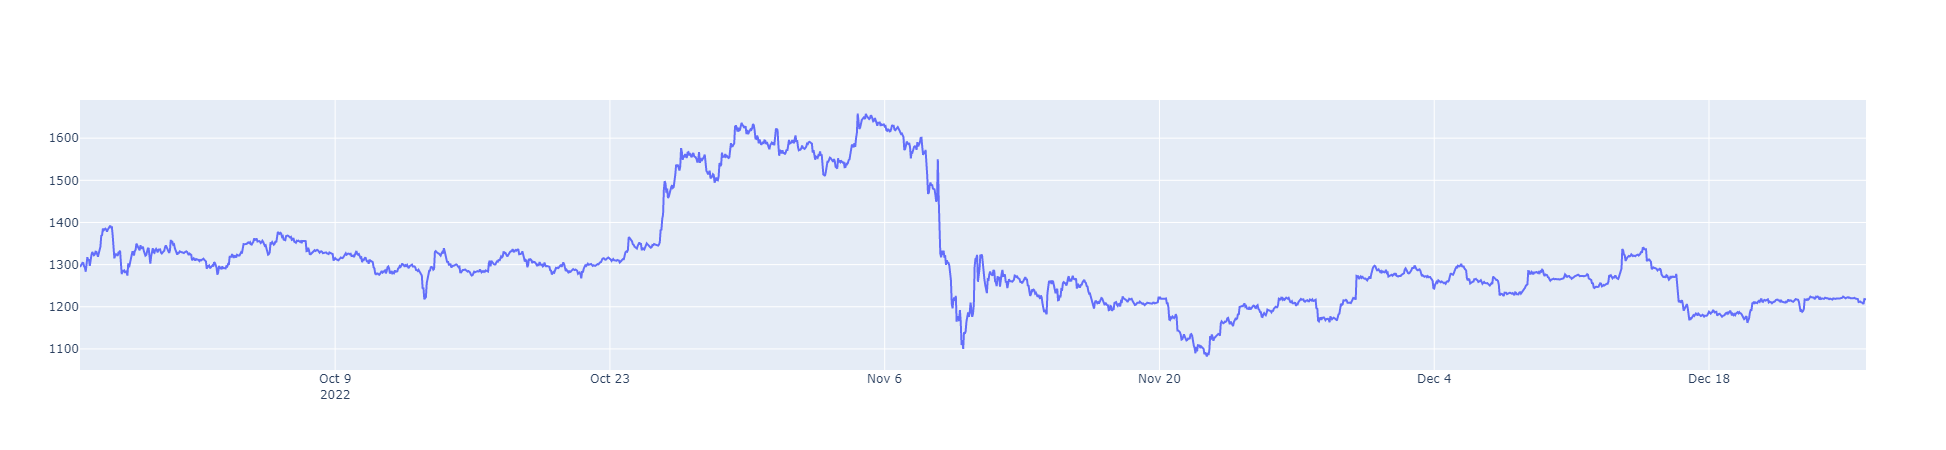

ALGO-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


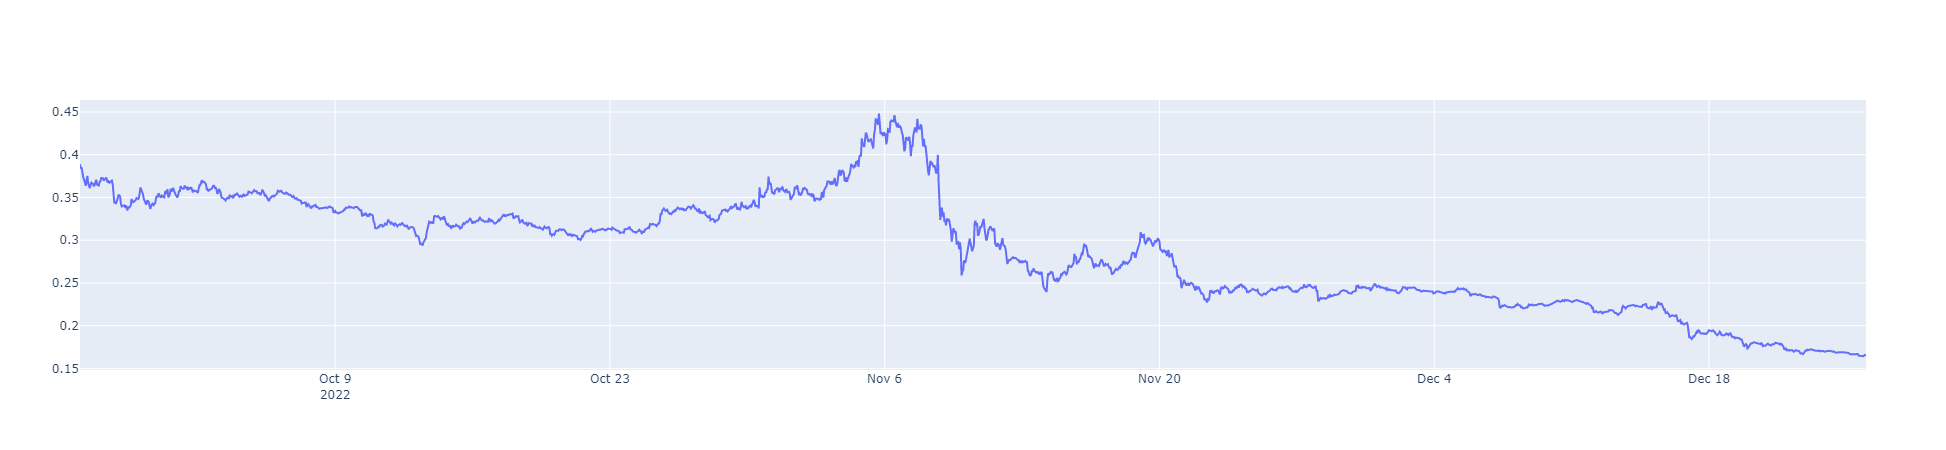

In [117]:
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
( getLine(getRates('ALGO-USD',  '3mo',  '1h')) )